# Initialisation 

In [1]:
from google.colab import drive 
drive.mount('drive')

Mounted at drive


In [2]:
import os 
os.chdir('drive/My Drive/Colab Notebooks/SAM')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Import des données 

Dans txt_file, pour chaque ligne on retrouve : 
* l'identifiant du morceau 
* le genre associé à ce morceau 
* Le numéro et la fréquence des mots contenus dans ce morceau 

In [4]:
path = "./msx_lyrics_genre.txt"

identifiants = []
labels = []
lyrics = {}

with open(path, "r") as file:
    reader = file.readlines()
    for i in range(len(reader)) : 
      morceau = reader[i].split(' ')
      identifiants.append(morceau[0])
      labels.append(morceau[1])
      lyrics[i] = morceau[2:]


In [5]:
print(len(reader)) 
# print(len(identifiants))
# print(len(labels))
# print(len(lyrics))
print(reader[6])
print(identifiants[6])
print(labels[6])
print(lyrics[6])

14750
TRAAIAE128F42AC53D Country 1:9 3:4 4:4 6:3 7:1 8:2 9:4 10:5 11:5 12:1 13:5 15:2 19:2 21:3 26:3 27:2 28:3 31:1 34:3 39:4 45:2 46:1 49:2 62:2 64:1 66:3 70:4 75:3 81:1 99:1 107:5 119:3 121:2 124:2 127:1 171:1 203:4 216:2 245:1 270:1 308:1 355:1 375:1 398:1 439:1 468:2 510:1 546:1 581:1 844:3 955:1 961:1 1281:1 1662:2 2453:2

TRAAIAE128F42AC53D
Country
['1:9', '3:4', '4:4', '6:3', '7:1', '8:2', '9:4', '10:5', '11:5', '12:1', '13:5', '15:2', '19:2', '21:3', '26:3', '27:2', '28:3', '31:1', '34:3', '39:4', '45:2', '46:1', '49:2', '62:2', '64:1', '66:3', '70:4', '75:3', '81:1', '99:1', '107:5', '119:3', '121:2', '124:2', '127:1', '171:1', '203:4', '216:2', '245:1', '270:1', '308:1', '355:1', '375:1', '398:1', '439:1', '468:2', '510:1', '546:1', '581:1', '844:3', '955:1', '961:1', '1281:1', '1662:2', '2453:2\n']


#Preprocessing des données 

On va pas utiliser l'identifiant pour notre dataset, on a donc les labels et lyrics à normaliser. On commence par les labels. 

##Labels 

In [10]:
label_vocab = {label: i for i,label in enumerate(labels)}
print(label_vocab)
print(len(label_vocab)) #il y'a 15 genres de musique 

labels_int = [label_vocab[label] for label in labels]
print(labels_int[0:5]) 

{'Rap': 14749, 'Metal': 14748, 'Jazz': 14712, 'Pop': 14744, 'Reggae': 14736, 'Rock': 14745, 'Country': 14740, 'Punk': 14671, 'Folk': 14683, 'RnB': 14747, 'Electronic': 14706, 'Latin': 14724, 'Blues': 14584, 'New_Age': 14010, 'World': 14270}
15
[14749, 14748, 14712, 14744, 14736]


## Lyrics 

Lyrics sous forme de bag-of-word pour éviter d'avoir des problèmes de droit d'auteur. On a un dictionnaire de 5000 mots et à chaque x:y : x correspond à l'indice du mot dans le dictionnaire (il commence à un), y correspond au nombre de fois que ce mot est apparu dans cette chanson. 

Pour choisir max_len on va regarder combien chaque morceau comporte de mots, puis on va tronquer à la valeur qui nous parait la moins discriminante pour les données. On peut tronquer à 250. 

(array([1.723e+03, 6.941e+03, 4.341e+03, 8.730e+02, 4.420e+02, 2.820e+02,
        1.050e+02, 3.500e+01, 6.000e+00, 2.000e+00]),
 array([  1. ,  43.7,  86.4, 129.1, 171.8, 214.5, 257.2, 299.9, 342.6,
        385.3, 428. ]),
 <a list of 10 Patch objects>)

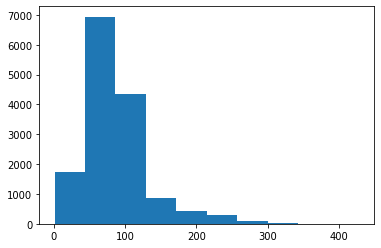

In [35]:
len_lyrics = []
for i in range(len(lyrics)):
  len_lyrics.append(len(lyrics[i]))

plt.hist(len_lyrics)

Pour chaque morceau on va avoir deux listes : l'une avec les mots présents dans la chanson et l'autre avec la fréquence d'apparition. 

In [39]:
max_len = 250
seen_words = np.zeros((len(lyrics),max_len))
words_frequency = np.zeros((len(lyrics),max_len))

for i in range(len(lyrics)): 
  s = [lyric.split(':')[0] for lyric in lyrics[i] ]
  l = [lyric.split(':')[1] for lyric in lyrics[i] ]
  l[-1] = l[-1].split('\n')[0]
  seen_words[i,:min(max_len,len(s))] = s[:min(max_len,len(s))]
  words_frequency[i,:min(max_len,len(l))] = l[:min(max_len,len(l))] 

In [40]:
print(seen_words)
print(words_frequency)

[[1. 2. 3. ... 0. 0. 0.]
 [1. 2. 3. ... 0. 0. 0.]
 [1. 2. 3. ... 0. 0. 0.]
 ...
 [1. 2. 3. ... 0. 0. 0.]
 [1. 2. 4. ... 0. 0. 0.]
 [1. 2. 3. ... 0. 0. 0.]]
[[39. 30. 10. ...  0.  0.  0.]
 [ 4. 11. 19. ...  0.  0.  0.]
 [23. 18. 31. ...  0.  0.  0.]
 ...
 [11. 31. 42. ...  0.  0.  0.]
 [ 3. 14.  7. ...  0.  0.  0.]
 [25.  8.  6. ...  0.  0.  0.]]


## Construction de X et Y 

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

max_len = 250
batch_size = 64
embed_size = 128
hidden_size = 128
device = torch.device('cuda') 

In [74]:
X = np.random.randint(2,size=(2,6))
print(X)
print(X[0,:3])
print(X[0,3:])

[[0 0 0 0 0 1]
 [0 1 1 1 0 1]]
[0 0 0]
[0 0 1]


In [80]:
X = np.zeros((len(lyrics), max_len*2)) #on va concaténer seen_words et words_frequency a la suite 

for i in range(len(lyrics)):
  X[i,:max_len] = seen_words[i] 
  X[i,max_len:] = words_frequency[i]

X = torch.from_numpy(X)
Y = torch.LongTensor(labels_int)

print(X.size())
print(Y.size())

torch.Size([14750, 500])
torch.Size([14750])


In [82]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.3)

print(X_train.size(),X_test.size())
print(Y_train.size(),Y_test.size())

torch.Size([10325, 500]) torch.Size([4425, 500])
torch.Size([10325]) torch.Size([4425])


In [83]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X_train, Y_train)
test_set = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False) #je les ai déjà shuffle avec train_test_split
test_loader = DataLoader(test_set, batch_size=batch_size)

## Fonctions pour les modèles : fit, perf et pred

In [86]:
def perf(model, loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    total_loss = correct = num = 0
    for x, y in loader:
      with torch.no_grad():
        x_seen_words = x[:,:max_len] 
        x_words_frequency = x[:,max_len:]
        y_scores = model(x_seen_words,x_words_frequency)
        loss = criterion(y_scores, y)
        y_pred = torch.max(y_scores, 1)[1]
        correct += torch.sum(y_pred.data == y)
        total_loss += loss.item()
        num += len(y)
    return total_loss / num, correct.item() / num

def fit(model, epochs):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):
        model.train()
        total_loss = num = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            x_seen_words = x[:,:max_len] 
            x_words_frequency = x[:,max_len:]
            y_scores = model(x_seen_words,x_words_frequency)
            loss = criterion(y_scores, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num += len(y)
        print(epoch, total_loss / num, *perf(model, test_loader))

def predict(model,loader):
   output = []
   for x, y in loader:
     with torch.no_grad():
       x_seen_words = x[:, :max_len]
       x_words_frequency = x[:, :max_len]
       y_scores = self(x_seen_words, x_words_frequency)
       y_pred = y_scores > 0.5
       output.append(y_pred.int())
   return output



#On commence par tester un RNN multimodal 

In [91]:
class RNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.embed = nn.Embedding(len(lyrics), embed_size)
    self.seen_words_rnn = nn.GRU(embed_size,hidden_size,num_layers=1,bidirectional=False, batch_first=True)
    self.words_frequency_rnn = nn.GRU(embed_size,hidden_size,num_layers=1,bidirectional=False, batch_first=True)
    self.seen_words_dropout = nn.Dropout(0.3)
    self.words_frequency_dropout = nn.Dropout(0.3)
    self.linear = nn.Linear(hidden_size*2,out_features=len(label_vocab)) #*2 parce que j'ai deux couches 
  
  def forward(self,x_seen_words,x_words_frequency):
    sw_embed = self.embed(x_seen_words)
    wf_embed = self.embed(x_words_frequency)
    output_sw,hidden_sw = self.seen_words_rnn(sw_embed)
    output_wf,hidden_wf = self.words_frequency_rnn(wf_embed)
    sw_drop = self.seen_words_dropout(hidden_sw)
    wf_drop = self.words_frequency_dropout(hidden_wf)
    cat = torch.cat((sw_drop,wf_drop),-1) #concatene et renvoie un tenseur 
    return self.decision(cat.contiguous())
  
rnn_model = RNN()
rnn_model.to(device)

RNN(
  (embed): Embedding(14750, 128)
  (seen_words_rnn): GRU(128, 128, batch_first=True)
  (words_frequency_rnn): GRU(128, 128, batch_first=True)
  (seen_words_dropout): Dropout(p=0.3, inplace=False)
  (words_frequency_dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=256, out_features=15, bias=True)
)

In [97]:
x_sw = X[:3,:max_len]
x_wf = X[:3,max_len:]

rnn_model(x_sw,x_wf)

RuntimeError: ignored